In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p /root/.kaggle
!scp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [1]:
!kaggle datasets download -d zalando-research/fashionmnist

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [ ]:
!unzip fashionmnist.zip -d fashiomnist

Archive:  fashionmnist.zip
  inflating: fashiomnist/fashion-mnist_test.csv  
  inflating: fashiomnist/fashion-mnist_train.csv  
  inflating: fashiomnist/t10k-images-idx3-ubyte  
  inflating: fashiomnist/t10k-labels-idx1-ubyte  
  inflating: fashiomnist/train-images-idx3-ubyte  
  inflating: fashiomnist/train-labels-idx1-ubyte  


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [ ]:
data = pd.read_csv("fashiomnist/fashion-mnist_train.csv")
print("Number of training:",data.shape[0])
data.head()

Number of training: 60000


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# метки классов
classes = data.iloc[:, 0].values
#classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}

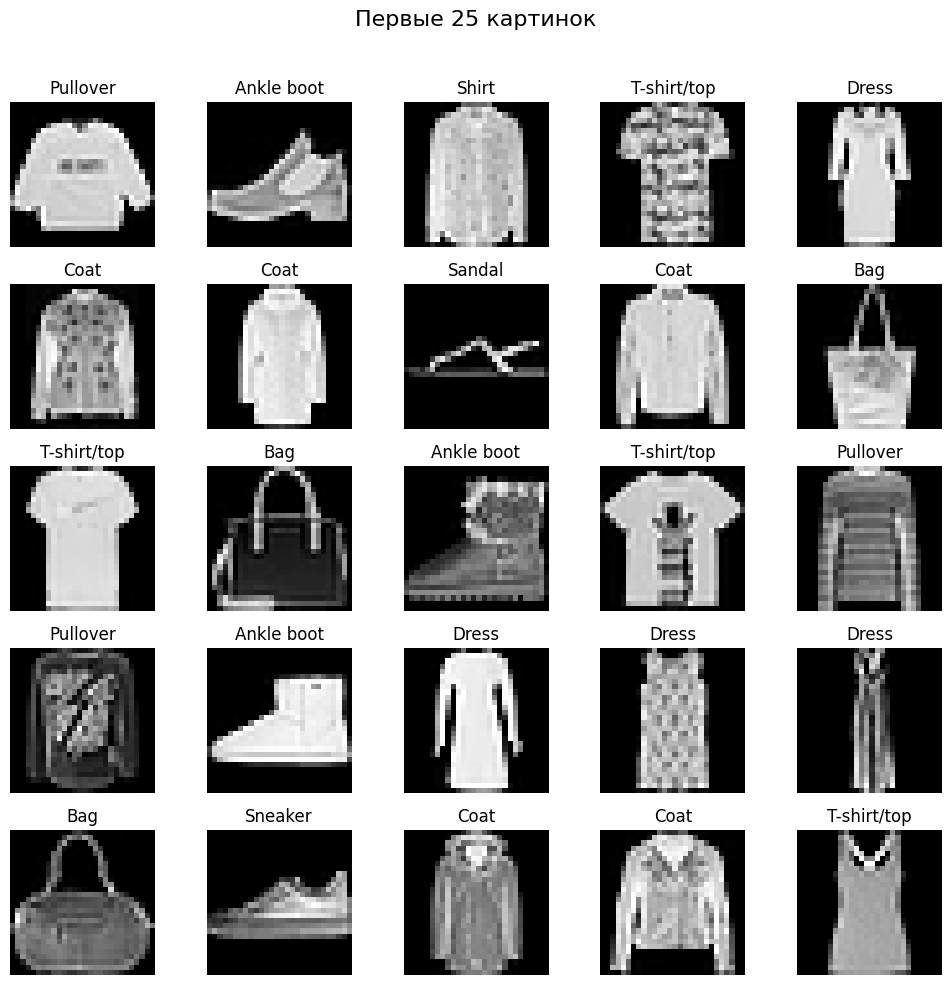

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle("Первые 25 картинок", fontsize=16)

# выведем первые 25 фоток из датасета с соотв названием классов
for i, ax in enumerate(axes.flat):
    img = data.iloc[i, 1:].values.reshape(28, 28) # ресайзаем в 28х28
    ax.imshow(img, cmap='gray') # Отображение в оттенках серого
    ax.axis('off') # убираем оси
    ax.set_title(f"{class_names[classes[i]]}")  # показываем названия классов

plt.tight_layout(rect=[0,0,1,0.96]) # регулируем макет в соотв с заголовком
plt.show()

<ipython-input-19-518d85d7957e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=classes, palette="viridis")


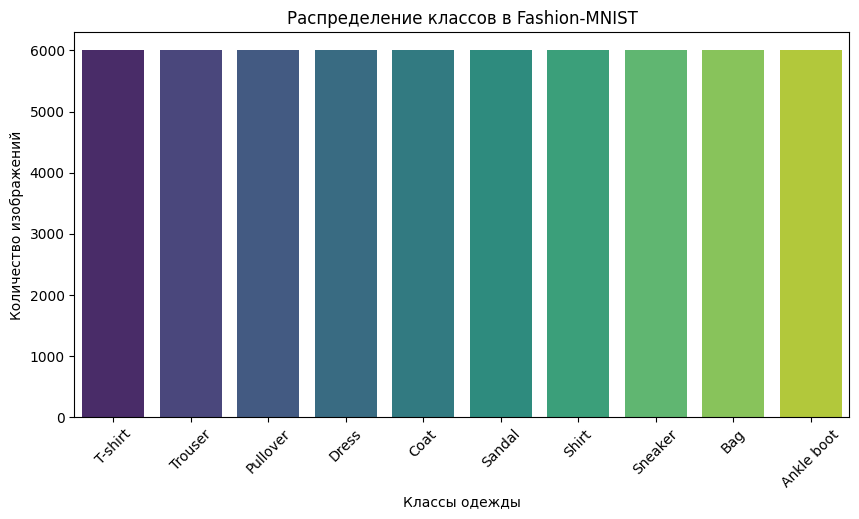

In [ ]:
# Создаем график
plt.figure(figsize=(10, 5))
sns.countplot(x=classes, palette="viridis")

# Подписи к графику
plt.xlabel("Классы одежды")
plt.ylabel("Количество изображений")
plt.title("Распределение классов в Fashion-MNIST")
plt.xticks(ticks=range(10), labels=[
    "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
], rotation=45)

plt.show()

In [ ]:
batch_size = 64
num_epochs = 12

# Разделяем данные на признаки и метки
X = data.iloc[:, 1:].values.astype(np.float32) / 255.0  # Нормализация
y = data.iloc[:, 0].values.astype(np.int64)

# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Преобразуем в тензоры
X_train = torch.tensor(X_train).view(-1, 1, 28, 28)  # Преобразуем в формат (N, C, H, W)
X_test = torch.tensor(X_test).view(-1, 1, 28, 28)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

# Создаем DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Определение модели MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Определение модели CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*7*7, 256)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Обучение и тестирование

def train(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    losses = []
    accuracies = []
    iterations = []

    total_iterations = 0  # Общее количество итераций

    for epoch in tqdm(range(num_epochs), desc="Training Progress", unit="epoch"):
        total_loss = 0
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(train_loader, 1):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            total_iterations += 1

            # Записываем данные каждые 500 итераций
            if total_iterations % 500 == 0:
                accuracy = 100 * correct / total
                print(f'\nIteration: {total_iterations}  Loss: {loss.item()}  Accuracy: {accuracy:.2f} %')

                iterations.append(total_iterations)  # Добавляем текущее значение итерации
                losses.append(total_loss / i)  # Средний loss за последние итерации
                accuracies.append(accuracy)  # Текущая точность

    # Визуализация результатов
    model_name = "MLP" if isinstance(model, MLP) else "CNN"

    plt.figure(figsize=(12, 5))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(iterations, losses, marker='o', label=f'Loss ({model_name})')
    plt.xlabel('Number of iterations')
    plt.ylabel('Loss')
    plt.title(f'Loss vs Number of iterations ({model_name})')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(iterations, accuracies, marker='o', color='red', label=f'Accuracy ({model_name})')
    plt.xlabel('Number of iterations')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Number of iterations ({model_name})')
    plt.legend()

    plt.show()


def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_images.extend(images.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())  # Сохраняем предсказания
            all_labels.extend(labels.cpu().numpy())  # Сохраняем истинные метки

    accuracy = 100 * correct / total
    model_name = "MLP" if isinstance(model, MLP) else "CNN"
    print(f'Accuracy of {model_name}: {accuracy:.2f}%')

    # Выбираем 64 случайных примера для визуализации
    np.random.seed(42)  # Фиксируем случайность для повторяемости
    indices = np.random.choice(len(all_images), 64, replace=False)

    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    fig.suptitle(f"Результаты работы {model_name}", fontsize=16)

    for i, ax in enumerate(axes.flat):
        img_idx = indices[i]
        img = all_images[img_idx].reshape(28, 28)  # Преобразуем в формат 28x28
        true_label = all_labels[img_idx]
        pred_label = all_preds[img_idx]

        color = 'green' if true_label == pred_label else 'red'  # Цвет заголовка

        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f"P: {class_names[pred_label]}\nT: {class_names[true_label]}",
                     fontsize=10, color=color)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Построение матрицы ошибок
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f'Confusion Matrix ({model_name})')
    plt.show()

    return accuracy


Training Progress:   0%|          | 0/12 [00:00<?, ?epoch/s]


Iteration: 500  Loss: 1.0732719898223877  Accuracy: 49.74 %


Training Progress:   8%|▊         | 1/12 [00:04<00:54,  5.00s/epoch]


Iteration: 1000  Loss: 0.8486207127571106  Accuracy: 69.74 %


Training Progress:  17%|█▋        | 2/12 [00:10<00:55,  5.53s/epoch]


Iteration: 1500  Loss: 0.5919331312179565  Accuracy: 72.77 %

Iteration: 2000  Loss: 0.5932857990264893  Accuracy: 77.84 %


Training Progress:  25%|██▌       | 3/12 [00:15<00:46,  5.19s/epoch]


Iteration: 2500  Loss: 0.599364161491394  Accuracy: 80.11 %


Training Progress:  33%|███▎      | 4/12 [00:20<00:40,  5.02s/epoch]


Iteration: 3000  Loss: 0.5559220314025879  Accuracy: 80.72 %

Iteration: 3500  Loss: 0.5662956237792969  Accuracy: 81.75 %


Training Progress:  42%|████▏     | 5/12 [00:26<00:36,  5.25s/epoch]


Iteration: 4000  Loss: 0.45313918590545654  Accuracy: 82.28 %


Training Progress:  50%|█████     | 6/12 [00:30<00:30,  5.10s/epoch]


Iteration: 4500  Loss: 0.5603921413421631  Accuracy: 82.60 %

Iteration: 5000  Loss: 0.2649468779563904  Accuracy: 83.11 %


Training Progress:  58%|█████▊    | 7/12 [00:36<00:26,  5.28s/epoch]


Iteration: 5500  Loss: 0.27415233850479126  Accuracy: 83.76 %


Training Progress:  67%|██████▋   | 8/12 [00:41<00:20,  5.11s/epoch]


Iteration: 6000  Loss: 0.37823885679244995  Accuracy: 83.68 %

Iteration: 6500  Loss: 0.5453603863716125  Accuracy: 83.97 %


Training Progress:  75%|███████▌  | 9/12 [00:46<00:14,  4.99s/epoch]


Iteration: 7000  Loss: 0.5264601707458496  Accuracy: 84.18 %


Training Progress:  83%|████████▎ | 10/12 [00:51<00:10,  5.22s/epoch]


Iteration: 7500  Loss: 0.48593398928642273  Accuracy: 84.48 %

Iteration: 8000  Loss: 0.5272377133369446  Accuracy: 84.53 %


Training Progress:  92%|█████████▏| 11/12 [00:56<00:05,  5.12s/epoch]


Iteration: 8500  Loss: 0.44722023606300354  Accuracy: 85.15 %


Training Progress: 100%|██████████| 12/12 [01:02<00:00,  5.20s/epoch]


Iteration: 9000  Loss: 0.3580397069454193  Accuracy: 85.08 %


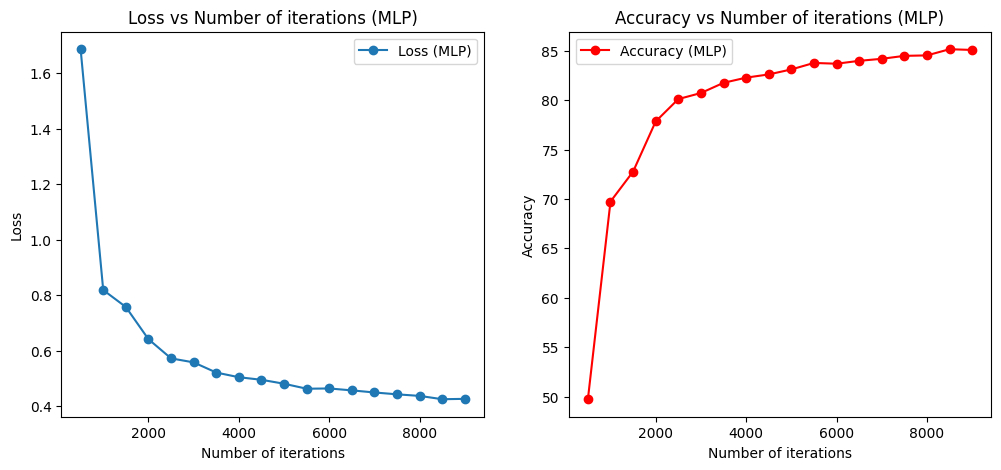

Accuracy of MLP: 84.98%


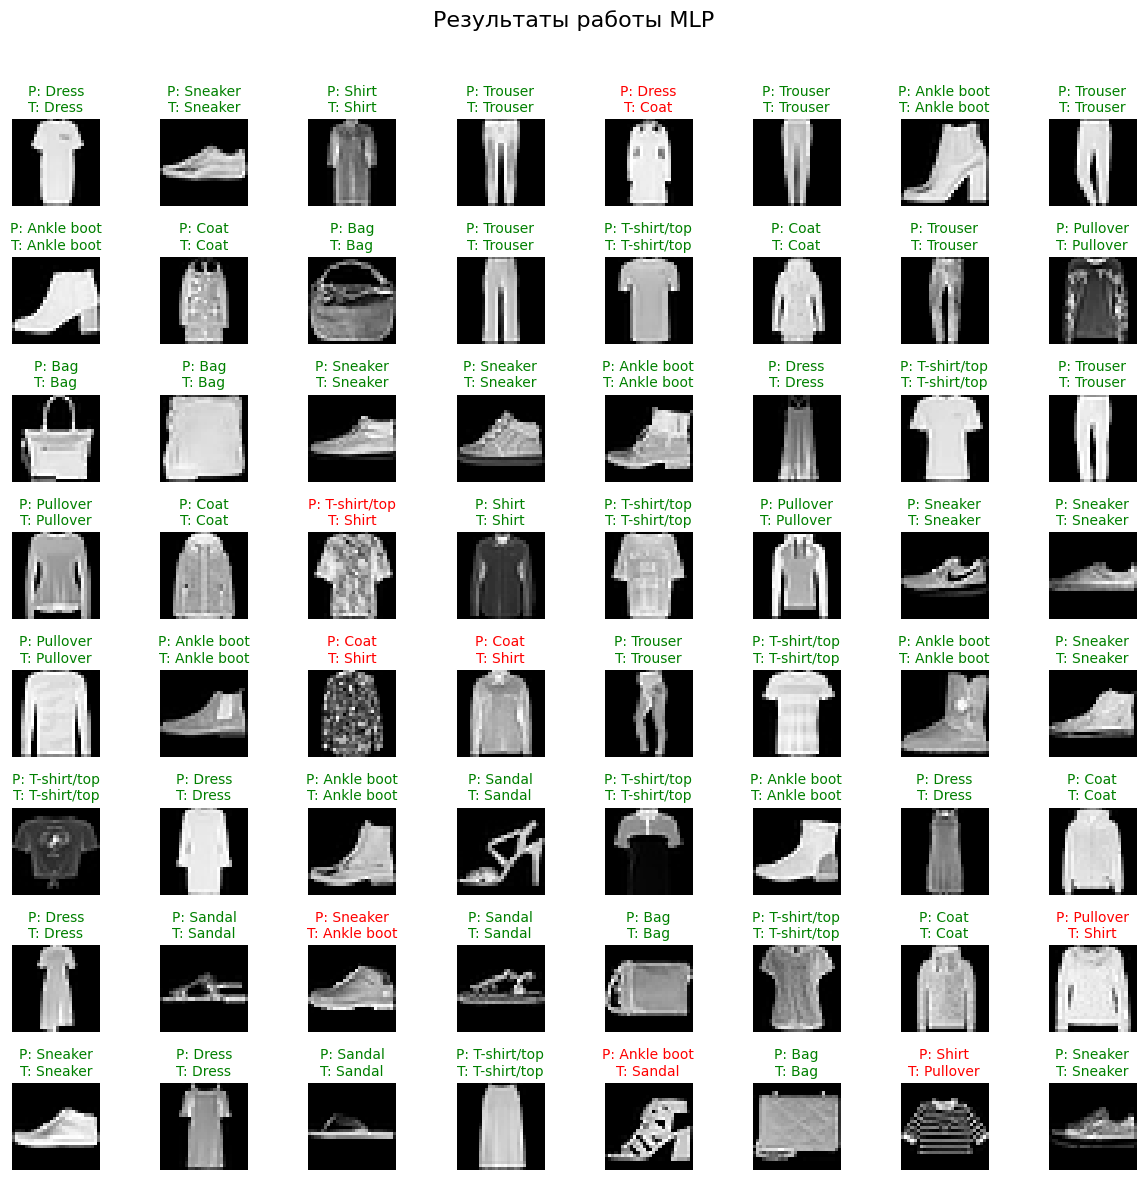

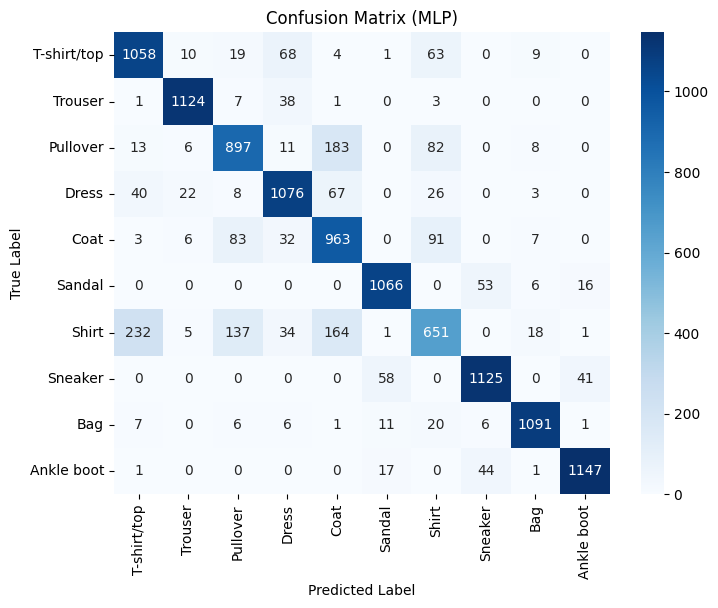

In [ ]:
# Обучение MLP
model_mlp = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_mlp.parameters(), lr=0.01)
train(model_mlp, train_loader, criterion, optimizer, num_epochs)
mlp_accuracy = test(model_mlp, test_loader)


Training Progress:   0%|          | 0/12 [00:00<?, ?epoch/s]


Iteration: 500  Loss: 0.9301118850708008  Accuracy: 55.88 %


Training Progress:   8%|▊         | 1/12 [00:58<10:46, 58.79s/epoch]


Iteration: 1000  Loss: 0.6080461740493774  Accuracy: 73.58 %


Training Progress:  17%|█▋        | 2/12 [01:58<09:56, 59.61s/epoch]


Iteration: 1500  Loss: 0.5129004716873169  Accuracy: 75.26 %

Iteration: 2000  Loss: 0.5846644043922424  Accuracy: 77.88 %


Training Progress:  25%|██▌       | 3/12 [02:59<08:58, 59.88s/epoch]


Iteration: 2500  Loss: 0.5543319582939148  Accuracy: 79.89 %


Training Progress:  33%|███▎      | 4/12 [03:57<07:54, 59.31s/epoch]


Iteration: 3000  Loss: 0.48750966787338257  Accuracy: 80.36 %

Iteration: 3500  Loss: 0.5904236435890198  Accuracy: 81.64 %


Training Progress:  42%|████▏     | 5/12 [04:57<06:55, 59.40s/epoch]


Iteration: 4000  Loss: 0.3423771262168884  Accuracy: 82.56 %


Training Progress:  50%|█████     | 6/12 [05:56<05:56, 59.47s/epoch]


Iteration: 4500  Loss: 0.62879878282547  Accuracy: 82.97 %

Iteration: 5000  Loss: 0.473155677318573  Accuracy: 83.70 %


Training Progress:  58%|█████▊    | 7/12 [06:55<04:56, 59.33s/epoch]


Iteration: 5500  Loss: 0.4048045575618744  Accuracy: 84.45 %


Training Progress:  67%|██████▋   | 8/12 [07:55<03:57, 59.32s/epoch]


Iteration: 6000  Loss: 0.3448696434497833  Accuracy: 84.62 %

Iteration: 6500  Loss: 0.34293851256370544  Accuracy: 85.17 %


Training Progress:  75%|███████▌  | 9/12 [08:54<02:58, 59.44s/epoch]


Iteration: 7000  Loss: 0.6020808219909668  Accuracy: 85.74 %


Training Progress:  83%|████████▎ | 10/12 [09:53<01:58, 59.13s/epoch]


Iteration: 7500  Loss: 0.44785797595977783  Accuracy: 86.02 %

Iteration: 8000  Loss: 0.23804378509521484  Accuracy: 86.50 %


Training Progress:  92%|█████████▏| 11/12 [10:53<00:59, 59.37s/epoch]


Iteration: 8500  Loss: 0.32523372769355774  Accuracy: 86.46 %


Training Progress: 100%|██████████| 12/12 [11:52<00:00, 59.40s/epoch]


Iteration: 9000  Loss: 0.36346447467803955  Accuracy: 86.70 %


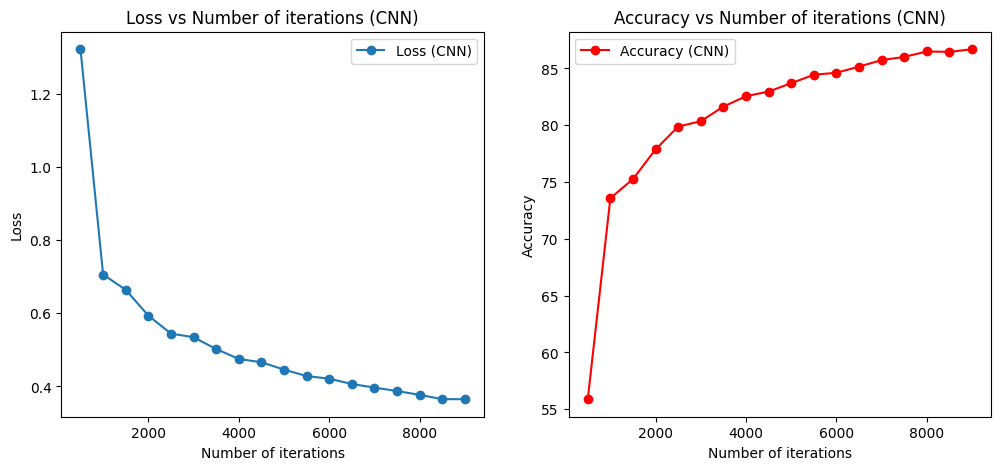

Accuracy of CNN: 84.42%


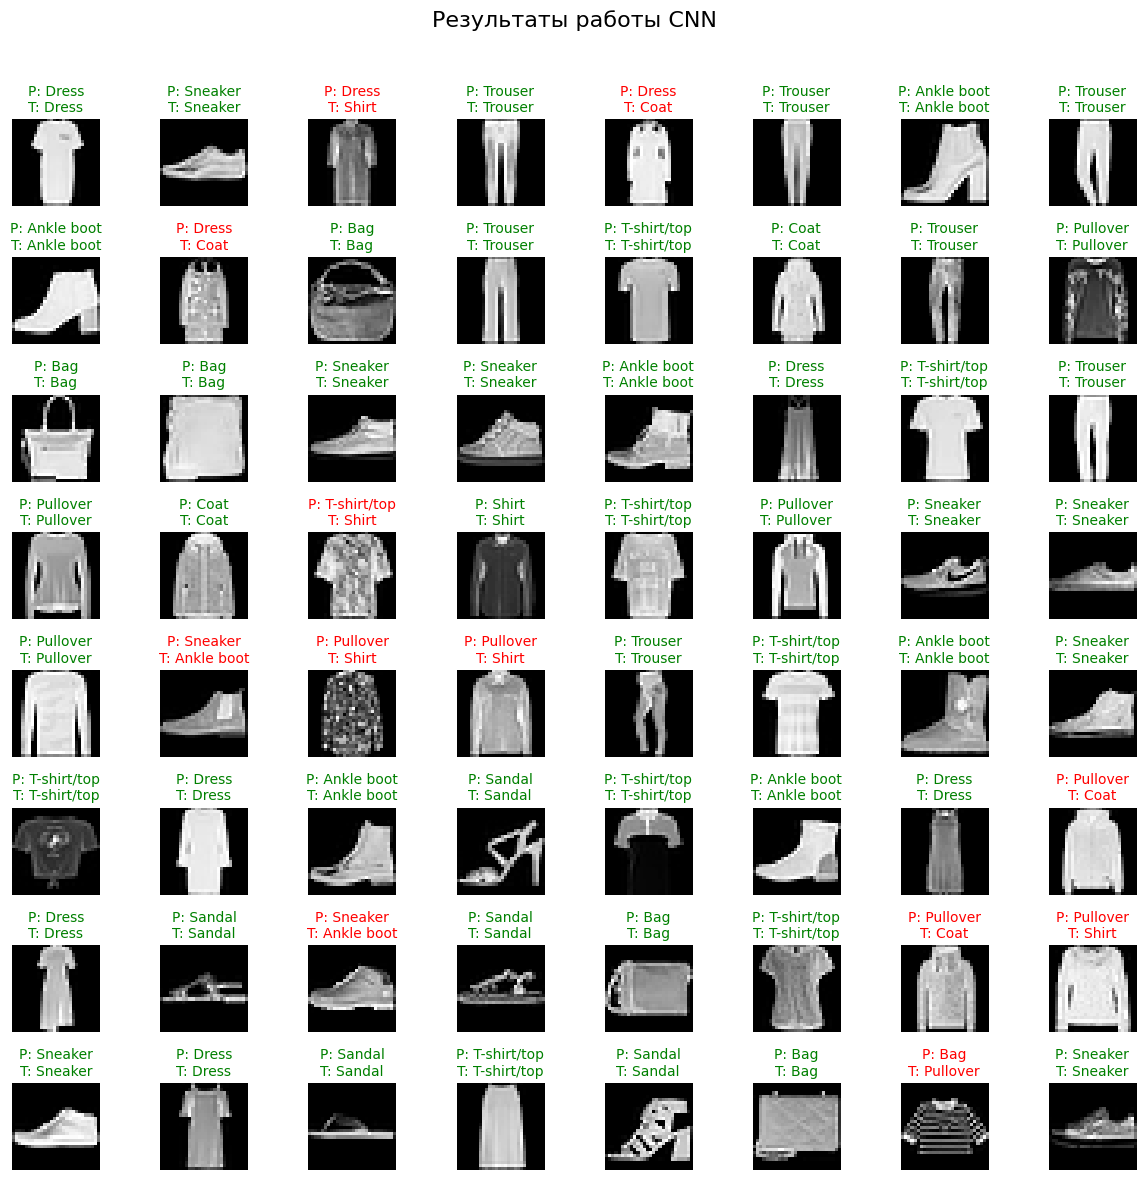

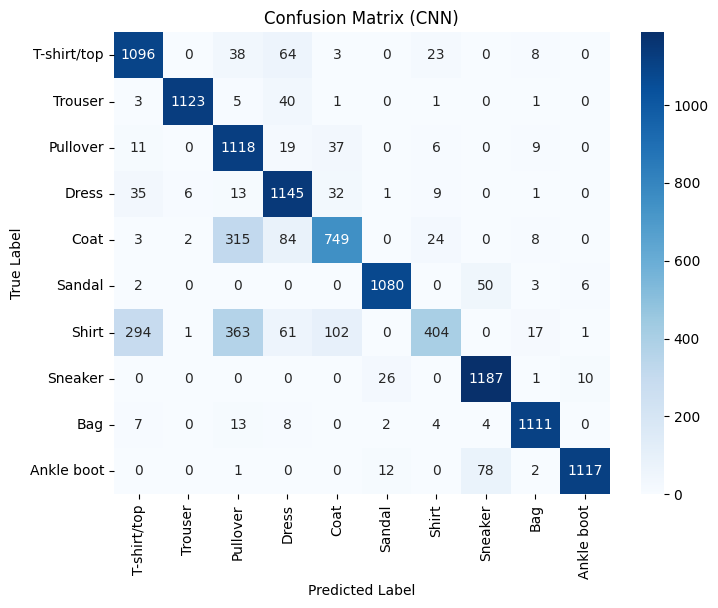

In [ ]:
# Обучение CNN
model_cnn = CNN()
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01)
train(model_cnn, train_loader, criterion, optimizer, num_epochs)
cnn_accuracy = test(model_cnn, test_loader)